# DataCollection
This notebook shows how get data from wiseair servers and integrating it with wheater informations coming from ARPA sensors

The final dataset will be indexed by date and time of the measurement done by each sensor. Each row reports information about
* sensor id (pot_id)
* pm1 levels
* pm2p5 levels
* pm4 levels
* pm10 levels
* humidity
* temperature
* wind speed  (from ARPA)
* rain levels (from ARPA)
* latitude
* longitude
* a binary weekend variable

Latitude and longitude are refereed to the sensor making the measurement (note: data coming from ARPA are taken with a different and single weather station located at Milano Lambrate, latitude and longitude reported do not refer to this station)

Data need to be hourly aggregated to have equally spaced samples in time before further processing, morover the need for hourly aggregation comes from the fact that ARPA data are given in intervals of one hour, thus data crossing cannot be done if wiseair sensors data and ARPA informations are not aligned.
Using daily average is not recommended because interesting patterns may be lost.

In [1]:
import sys
sys.path.insert(0, '../src/')

from DataCollector import DataCollector
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# graphics settings
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcdefaults()
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})

import warnings
warnings.filterwarnings("ignore")

In [2]:
# COLLECT DATA, THIS REQUIRES TIME... WAIT UNTIL FINISH BEFORE RUNNING NEXT CELLS
dataCollector = DataCollector()

BEGIN_DATE = "2020-06-01"
END_DATE   = "2021-02-07"

In [3]:
# write a fresh CSV file containing data for the selected period
# avoid to call this function if you already have a dataset, call updateData() instead
dataCollector.getData(BEGIN_DATE, END_DATE, "../data/rawdata.csv")

fetching data from Wiseair server
progress [################################################################################] 100.0%
got not null data from 93 sensors                                                                                                    
data stored in ../data/rawdata.csv


In [4]:
data = pd.read_csv("../data/rawdata.csv")

## Feature selection and integration

In [5]:
# ask to wiseair server for extra informations
pots = data['pot_id'].unique()
auxFeatures = ["latitude", "longitude", "is_on_the_road"]

# returns a dataframe with a pot_id column by default and the requested features
auxInfo = dataCollector.getAuxiliaryFeatures(auxFeatures, pots)

# valid keys to ask are: park_id, floor, is_on_the_road, city, country, streetname, housenumber, postalcode, 
#                        ambassador, latitude, longitude, pm1, pm2p5_zone, pm4, pm10_zone, created_at
auxInfo.head()

,pot_id,latitude,longitude,is_on_the_road
0,1157,41.826132,12.395317,5
1,1018,45.484161,9.209361,0
2,1016,45.524714,9.122232,1
3,1020,45.513175,9.134600,0
4,1022,45.462578,9.128191,1


In [6]:
# merge auxInfo with data
data = pd.merge(data, auxInfo, on = "pot_id", how="outer")
data.info()

# index by date
data["created_at"] = pd.to_datetime(data["created_at"])
data.set_index("created_at", inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 937610 entries, 0 to 937609
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   created_at                       937610 non-null  object 
 1   id                               937610 non-null  int64  
 2   location_id                      937610 non-null  int64  
 3   pot_id                           937610 non-null  int64  
 4   pm2p5                            937610 non-null  int64  
 5   pm10                             937610 non-null  float64
 6   pm1SPS                           937610 non-null  float64
 7   pm2p5SPS                         937610 non-null  int64  
 8   pm4SPS                           937610 non-null  float64
 9   pm10SPS                          937610 non-null  float64
 10  millisSpentMeasuring             937608 non-null  float64
 11  millisSpentConnecting            937608 non-null  float64
 12  mi

In [7]:
# keep only interesting features
interesting = ["pm1SPS", "pm2p5SPS", "pm4SPS", "pm10SPS", "temperature_sht", "humidity_sht", 
               "pot_id", "latitude", "longitude"]

for feature in list(data.columns.values):
    if feature not in interesting:
        data.drop(feature, axis = 1, inplace = True)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 937610 entries, 2020-09-04 22:23:31 to 2021-02-06 23:00:06
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   pot_id           937610 non-null  int64  
 1   pm1SPS           937610 non-null  float64
 2   pm2p5SPS         937610 non-null  int64  
 3   pm4SPS           937610 non-null  float64
 4   pm10SPS          937610 non-null  float64
 5   temperature_sht  937610 non-null  float64
 6   humidity_sht     937610 non-null  float64
 7   latitude         937610 non-null  float64
 8   longitude        937610 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 71.5 MB


In [8]:
data.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,latitude,longitude
created_at,,,,,,,,,
2020-09-04 22:23:31,1157,9.39,10,9.93,9.93,-9.05,20.52,41.826132,12.395317
2020-09-04 22:25:28,1157,12.54,13,13.26,13.26,-7.86,17.70,41.826132,12.395317
2020-09-04 22:30:15,1157,13.30,14,14.06,14.06,-8.53,29.28,41.826132,12.395317
2020-09-04 22:35:14,1157,12.75,13,13.49,13.49,-8.60,26.16,41.826132,12.395317
2020-09-04 22:40:14,1157,13.28,14,14.04,14.04,-8.67,25.66,41.826132,12.395317


## Hourly aggregation

Data are sampled with non-regular frequency. In order to have equally spaced points in time we perform an hourly aggregation. Aggregating data hourly does not remove relevant patterns, as might happen with coarse aggregation (daily aggregation)

In [9]:
# group data on base of sensors id
groupedData = data.groupby('pot_id', as_index=False)

averagedData = pd.DataFrame()
potID = set(data['pot_id'])

# average data by sensor id
for y in potID:
    tmp = groupedData.get_group(y).resample('H').mean()
    tmp['pot_id']    = tmp['pot_id'].fillna(y)
    
    # extra features are not function of time, fill NaN with last valid not NaN
    for feature in set(auxFeatures) & set(interesting) :
        tmp[feature]  = tmp[feature].fillna(method = "ffill")
        
    averagedData = pd.concat([averagedData, tmp])

# recast pot_id to integer
averagedData['pot_id'] = averagedData['pot_id'].astype(int)

It might be interesting to see if the weekend/weekday distinction has some impact on the response variable. We extrapolate this information from the datetime index and integrate a binary variable weekend which is 1 when the datetime index corresponds to a weekend day (saturday/sunday), otherwise is set to 0

In [10]:
# define a function returning, given a datetime object, 1 if weekend, 0 otherwise
def isWeekend(datetimeIndex):
    weekday = datetimeIndex.weekday()
    if weekday < 5: return 0
    else: return 1

# apply the function to the dataset and store the result in a column
averagedData["created_at"] = averagedData.index
averagedData["weekend"] = averagedData.apply(lambda row: isWeekend(row["created_at"]), axis = 1)
averagedData.drop("created_at", axis = 1, inplace = True)

averagedData.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,latitude,longitude,weekend
created_at,,,,,,,,,,
2020-10-21 09:00:00,1538,49.371667,52.166667,59.645000,60.308333,13.575000,47.853333,45.524747,9.122091,0
2020-10-21 10:00:00,1538,35.226667,38.250000,41.535833,41.918333,19.441667,34.597500,45.524747,9.122091,0
2020-10-21 11:00:00,1538,31.755833,34.333333,36.597500,36.868333,23.794167,27.140833,45.524747,9.122091,0
2020-10-21 12:00:00,1538,42.964167,45.583333,48.022500,48.255000,22.394167,30.137500,45.524747,9.122091,0
2020-10-21 13:00:00,1538,36.373333,39.166667,40.998333,41.224167,24.818333,25.490833,45.524747,9.122091,0


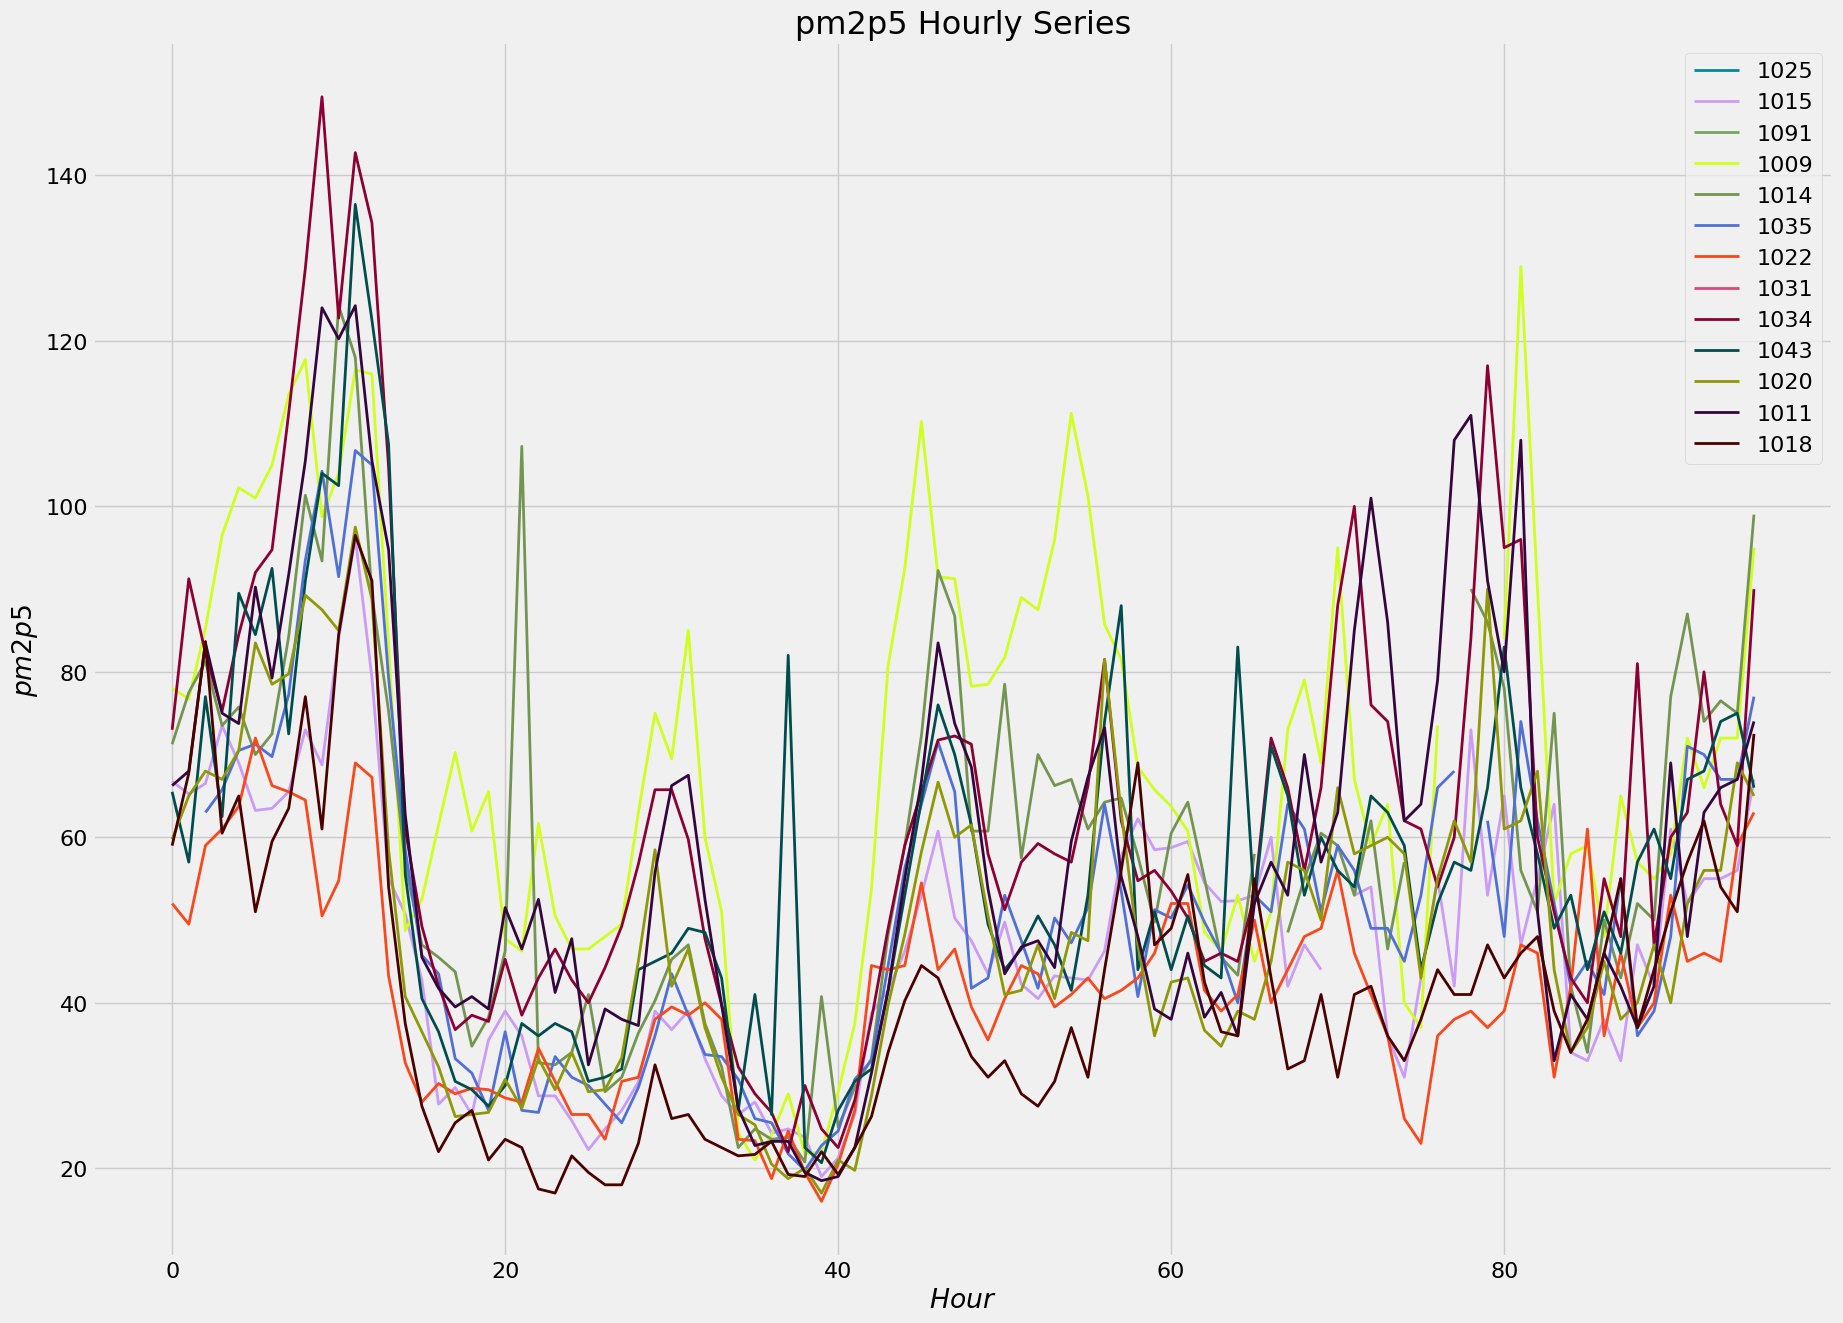

In [11]:
# just a plot to show some data... only the last 4 days are showed

endDate = datetime.strptime(END_DATE, "%Y-%m-%d")
startDate = endDate - timedelta(days = 4)

sensorsToPlot = [1025, 1015, 1091, 1009, 1014, 1035, 1022, 1031, 1034, 1043, 1020, 1011, 1018]

mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(sensorsToPlot), replace=False)

plt.figure(figsize=(8,6))
for j,i in enumerate(sensorsToPlot):
    tmp = averagedData.loc[averagedData['pot_id'] == i]
    tmp = tmp[startDate : endDate]
    
    tmp['hour'] = [d.strftime('%H') for d in tmp.index]
    tmp['colid'] = range(len(tmp['hour']))
    plt.plot('colid', 'pm2p5SPS', data=tmp, color=mycolors[j], label=i)
        
plt.gcf().set_size_inches(20, 15)
plt.gca().set(ylabel='$pm2p5$', xlabel='$Hour$')
plt.title("pm2p5 Hourly Series")
plt.legend()
plt.show()

## Weather data integration

wheater data are available with hourly frequency. Need to average available data hourly before integrating further informations from ARPA sensors. Data from ARPA sensors are joined to Wiseair data on the base of the datetime index. Be carefull to use ARPA data up to dated with respect to data collected from Wiseair (otherwise athmospheric informations as wind speed and rain levels will be NaN for days for which no data are supplied)

In [16]:
# weather data integration (data from 01-05-2020 to 25-10-2020)

# importing data from external files...
windSpeed = pd.read_csv('../data/datiArpaVento-01052020-07022021.csv', 
                        names=["ID", "Date", "wind"], header=0)
windSpeed.drop("ID", axis = 1, inplace = True)
windSpeed["Date"] = pd.to_datetime(windSpeed["Date"])
windSpeed.set_index("Date", inplace=True)

rainLevel = pd.read_csv('../data/datiArpaPrecipitazioni-01052020-07022021.csv', 
                        names=["ID", "Date", "rain"], header=0)
rainLevel.drop("ID", axis = 1, inplace = True)
rainLevel["Date"] = pd.to_datetime(rainLevel["Date"])
rainLevel.set_index("Date", inplace=True)

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,latitude,longitude,weekend
created_at,,,,,,,,,,
2020-10-21 09:00:00,1538,49.371667,52.166667,59.645000,60.308333,13.575000,47.853333,45.524747,9.122091,0
2020-10-21 10:00:00,1538,35.226667,38.250000,41.535833,41.918333,19.441667,34.597500,45.524747,9.122091,0
2020-10-21 11:00:00,1538,31.755833,34.333333,36.597500,36.868333,23.794167,27.140833,45.524747,9.122091,0
2020-10-21 12:00:00,1538,42.964167,45.583333,48.022500,48.255000,22.394167,30.137500,45.524747,9.122091,0
2020-10-21 13:00:00,1538,36.373333,39.166667,40.998333,41.224167,24.818333,25.490833,45.524747,9.122091,0


In [26]:
# dataset merge
finalData = averagedData
finalData = finalData.join(windSpeed, how='inner')
finalData = finalData.join(rainLevel, how='inner')

finalData.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,latitude,longitude,weekend,wind,rain
2020-06-24 12:00:00,1002,7.084286,7.857143,8.072857,8.124286,39.671429,36.662857,45.529613,9.214590,0,2.4,0.0
2020-06-24 13:00:00,1002,6.026000,6.600000,6.648000,6.672000,41.884000,31.278000,45.529614,9.214590,0,2.5,0.0
2020-06-24 13:00:00,1011,5.930000,6.444444,6.437778,6.457778,35.605556,35.506667,45.545528,9.074032,0,2.5,0.0
2020-06-24 14:00:00,1032,5.405000,5.750000,5.997500,6.022500,32.897500,28.510000,45.508385,9.208656,0,2.4,0.0
2020-06-24 14:00:00,1002,6.091818,6.545455,6.590909,6.604545,39.540000,35.771818,45.529613,9.214590,0,2.4,0.0


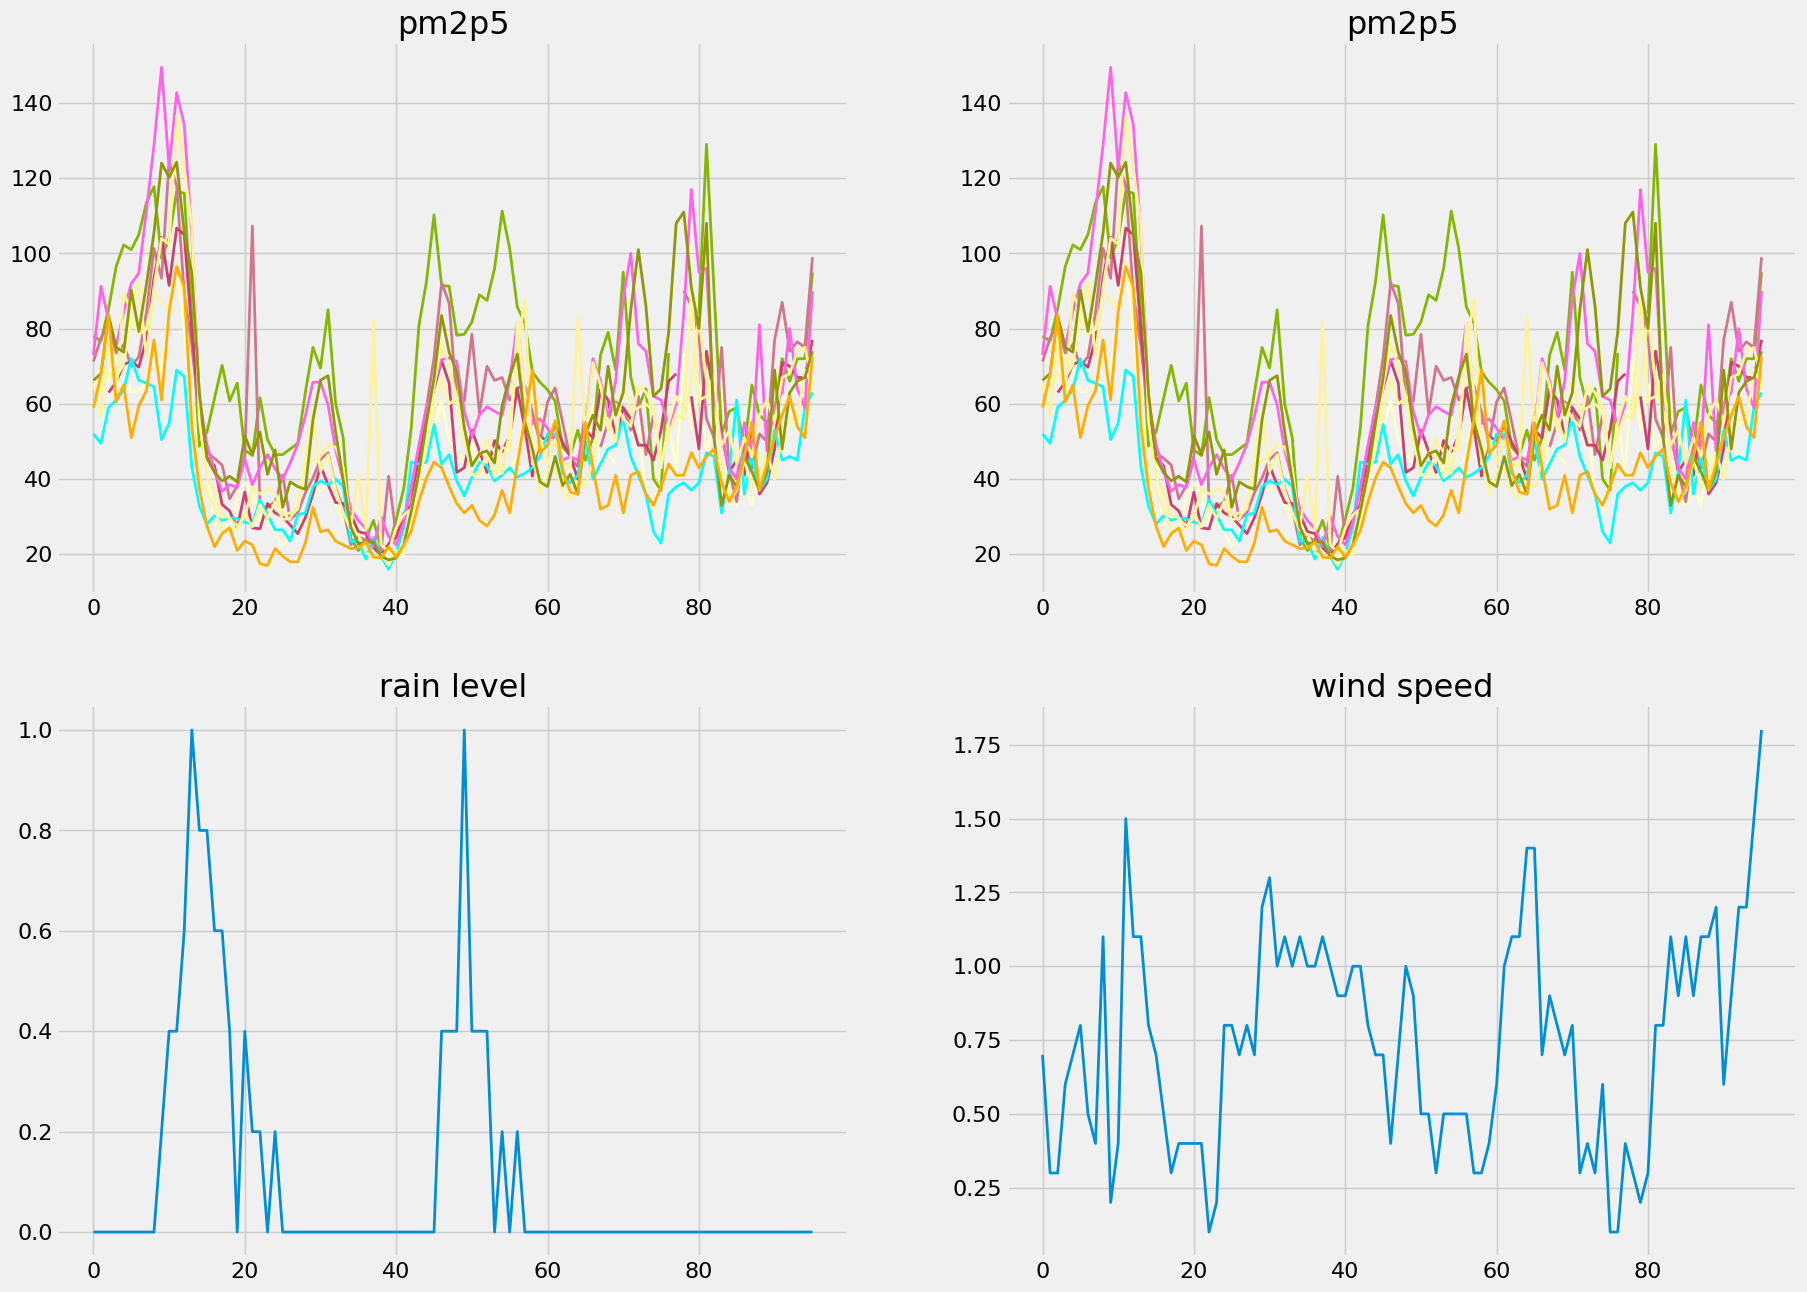

In [27]:
# final plot to show some covariates as function of time. Only the last 4 days are showed

sensorsToPlot = [1025, 1015, 1091, 1009, 1014, 1035, 1022, 1031, 1034, 1043, 1020, 1011, 1018]
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(sensorsToPlot), replace=False)

fig, axs = plt.subplots(2,2)
for j,i in enumerate(sensorsToPlot):
    tmp = finalData.loc[finalData['pot_id'] == i]
    tmp = tmp[startDate : endDate]
    
    tmp['hour'] = [d.strftime('%H') for d in tmp.index]
    tmp['colid'] = range(len(tmp['hour']))
    axs[0,0].plot('colid', 'pm2p5SPS', data=tmp, color=mycolors[j], label=i)
    axs[0,1].plot('colid', 'pm2p5SPS', data=tmp, color=mycolors[j], label=i)

axs[1,0].plot('colid', 'rain', data=tmp)
axs[1,1].plot('colid', 'wind', data=tmp)

axs[0,0].set_title("pm2p5")
axs[0,1].set_title("pm2p5")
axs[1,0].set_title("rain level")
axs[1,1].set_title("wind speed")

plt.gcf().set_size_inches(20, 15)
plt.show()

The final dataset can now be esported in csv and used for next studies

In [28]:
finalData.index.name = "created_at"
finalData.to_csv("../data/tsData2.csv")